## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

## Data Info

In [89]:
data_path = "Data/RTA Dataset.csv"

df = pd.read_csv(data_path)
df.head()

Time Day_of_week  ...           Cause_of_accident Accident_severity
0  17:02:00      Monday  ...             Moving Backward     Slight Injury
1  17:02:00      Monday  ...                  Overtaking     Slight Injury
2  17:02:00      Monday  ...   Changing lane to the left    Serious Injury
3   1:06:00      Sunday  ...  Changing lane to the right     Slight Injury
4   1:06:00      Sunday  ...                  Overtaking     Slight Injury

[5 rows x 32 columns]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [91]:
# we can see that apart from missing values we have values mark as 'Unknown' in the dataset
df.describe(include='object')

Time Day_of_week  ... Cause_of_accident Accident_severity
count      12316       12316  ...             12316             12316
unique      1074           7  ...                20                 3
top     15:30:00      Friday  ...     No distancing     Slight Injury
freq         120        2041  ...              2263             10415

[4 rows x 30 columns]

In [92]:
# replcing all NA and unknown values with numpy NaN
df.replace(['na', 'Unknown'], np.nan, inplace=True)

In [93]:
df.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver             1548
Sex_of_driver                   178
Educational_level               841
Vehicle_driver_relation         593
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        6811
Defect_of_vehicle              4427
Area_accident_occured           261
Lanes_or_Medians                442
Road_allignment                 142
Types_of_Junction              1078
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions              292
Type_of_collision               169
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                396
Casualty_class                 4443
Sex_of_casualty                4443
Age_band_of_casualty           4443
Casualty_severity              4443
Work_of_casuality           

## Cleaning Missing Values

In [94]:
# we fill high missing cols with unknown instead of mode
cols_fill_unknown = [
    'Age_band_of_driver', 
    'Service_year_of_vehicle',
    'Types_of_Junction',
    'Casualty_class',
    'Sex_of_casualty',
    'Age_band_of_casualty',
    'Work_of_casuality',
    'Casualty_severity',
    'Fitness_of_casuality',
    'Defect_of_vehicle'
]

df[cols_fill_unknown] = df[cols_fill_unknown].fillna('Unknown')

In [95]:
df.columns[df.isna().any()]

Index(['Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Vehicle_movement', 'Cause_of_accident'],
      dtype='object')

In [96]:
cols_fill_mode = [
    'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation',
    'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
    'Vehicle_movement', 'Cause_of_accident' 
]


mode = df[cols_fill_mode].mode().iloc[0]
df[cols_fill_mode] = df[cols_fill_mode].fillna(mode)

In [97]:
df.duplicated().sum()

np.int64(0)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            12316 non-null  object
 5   Vehicle_driver_relation      12316 non-null  object
 6   Driving_experience           12316 non-null  object
 7   Type_of_vehicle              12316 non-null  object
 8   Owner_of_vehicle             12316 non-null  object
 9   Service_year_of_vehicle      12316 non-null  object
 10  Defect_of_vehicle            12316 non-null  object
 11  Area_accident_occured        12316 non-null  object
 12  Lanes_or_Medians             12316 non-null  object
 13  Road_allignment              12

## Feature Engineering

In [99]:
df['hour_of_day'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

df.drop(columns=['Time'], inplace=True)

In [132]:
df['Is_Weekend'] = df['Day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [133]:
df['Dark_and_Wet'] = ((df['Light_conditions'] == 'Darkness - no lighting') & 
                      (df['Road_surface_conditions'] == 'Wet or damp')).astype(int)

## EDA

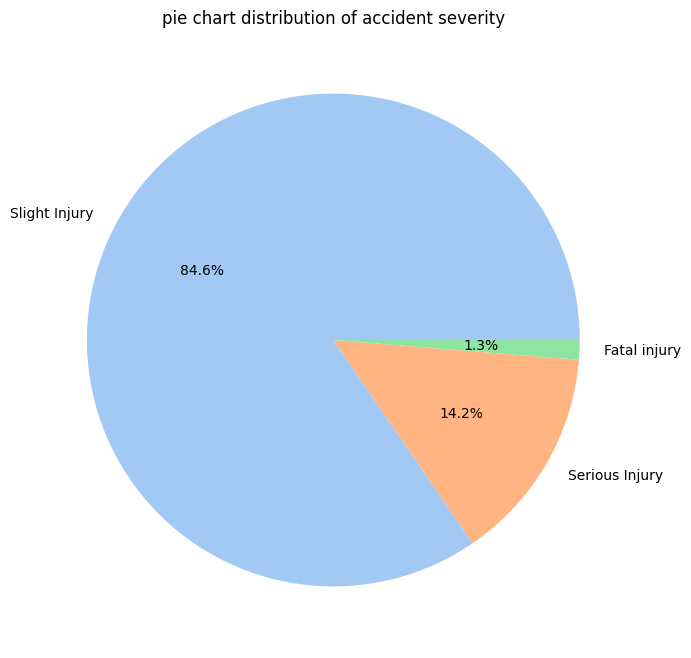

In [134]:
plt.figure(figsize=(12, 8))

data = df['Accident_severity'].value_counts()
label = data.index

plt.pie(data, labels=label, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('pie chart distribution of accident severity')
plt.show()

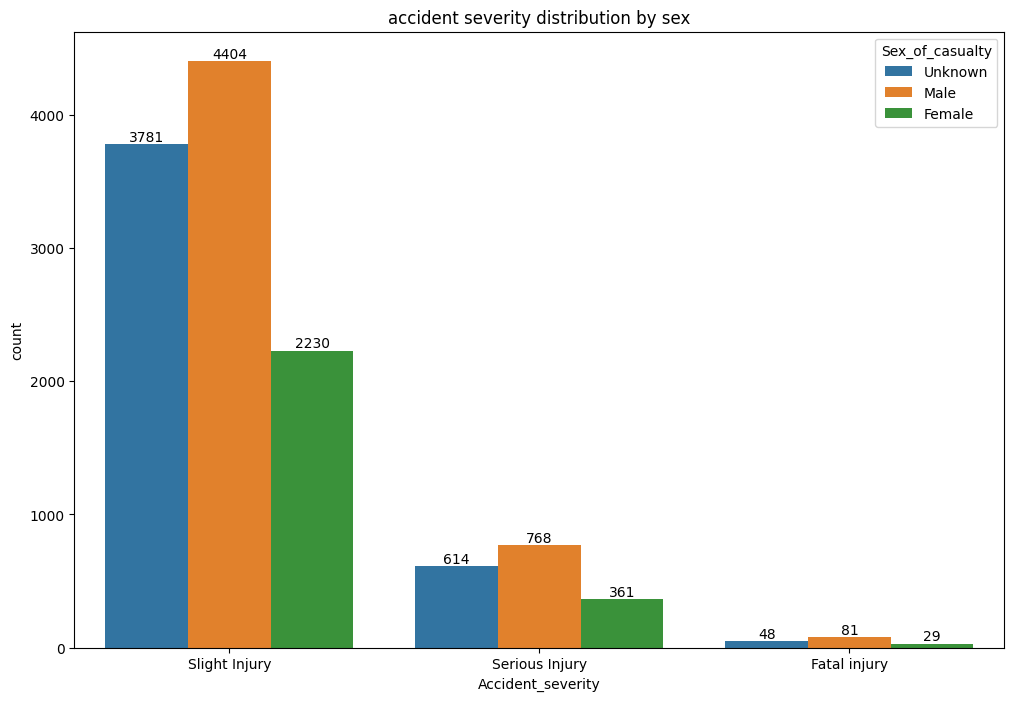

In [135]:
# severity related plots

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df, x='Accident_severity', hue='Sex_of_casualty')
plt.title('accident severity distribution by sex')
for cont in ax.containers:
    ax.bar_label(cont)
plt.show()

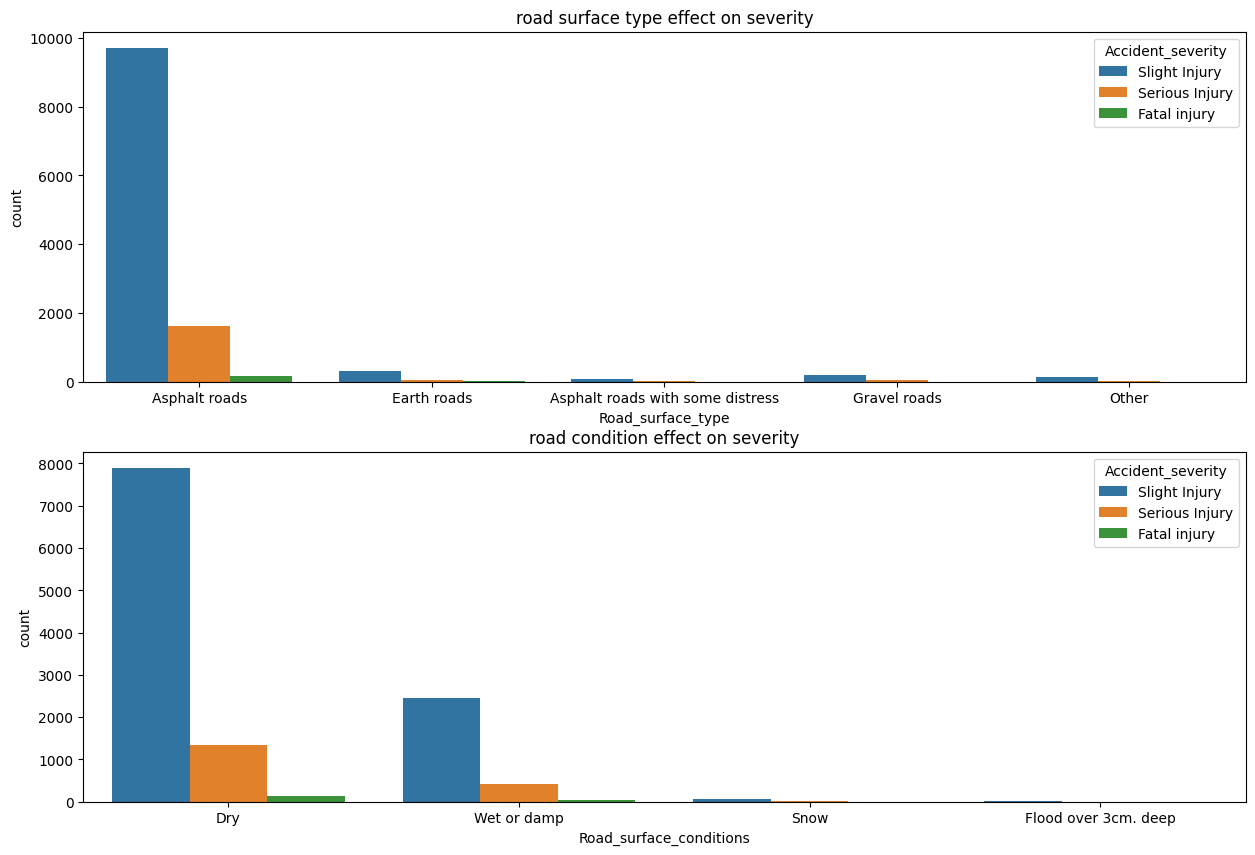

In [136]:
# enviroment realted plots - road

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.countplot(data=df, x='Road_surface_type', hue='Accident_severity')
plt.title('road surface type effect on severity')

plt.subplot(2, 1, 2)
sns.countplot(data=df, x='Road_surface_conditions', hue='Accident_severity')
plt.title('road condition effect on severity')

plt.show()

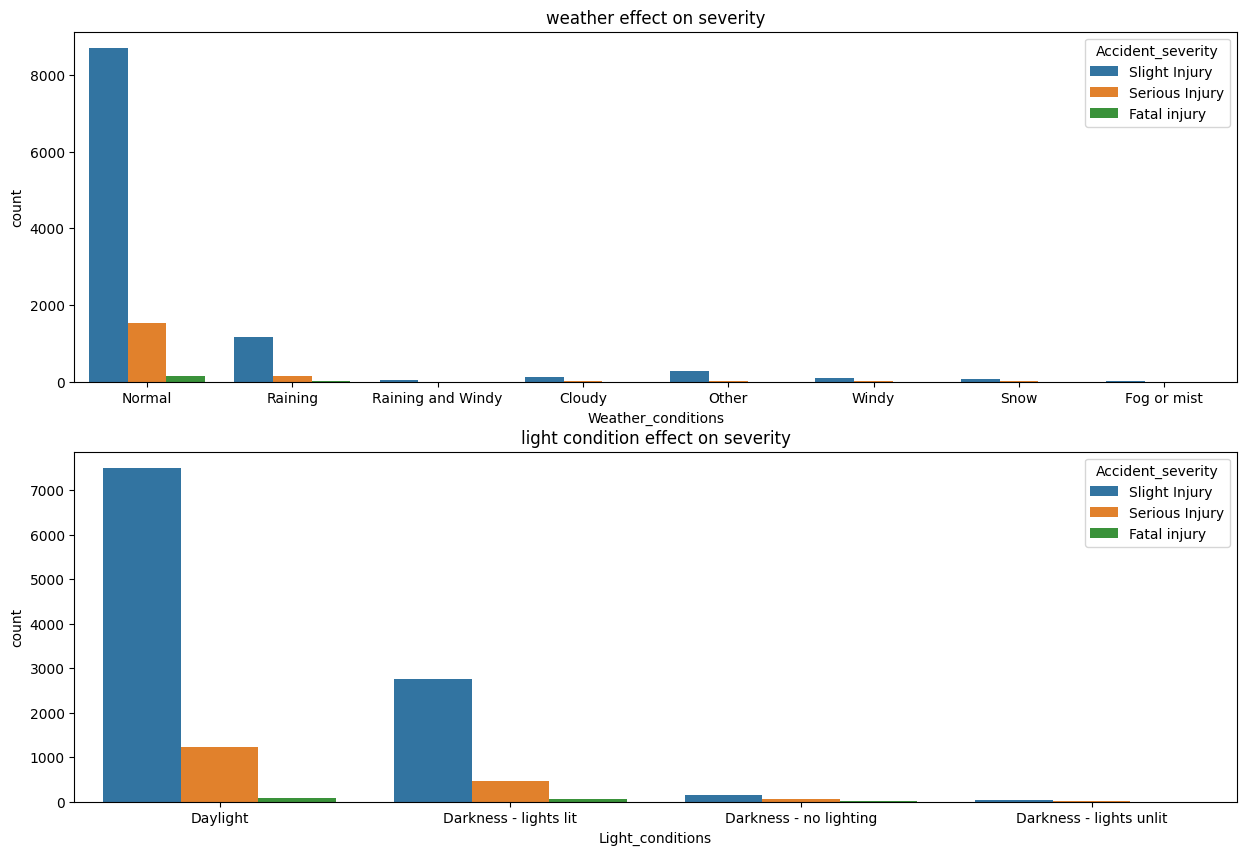

In [137]:
# enviroment related plots - weather and light 

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.countplot(data=df, x='Weather_conditions', hue='Accident_severity')
plt.title('weather effect on severity')

plt.subplot(2, 1, 2)
sns.countplot(data=df, x='Light_conditions', hue='Accident_severity')
plt.title('light condition effect on severity')

plt.show()

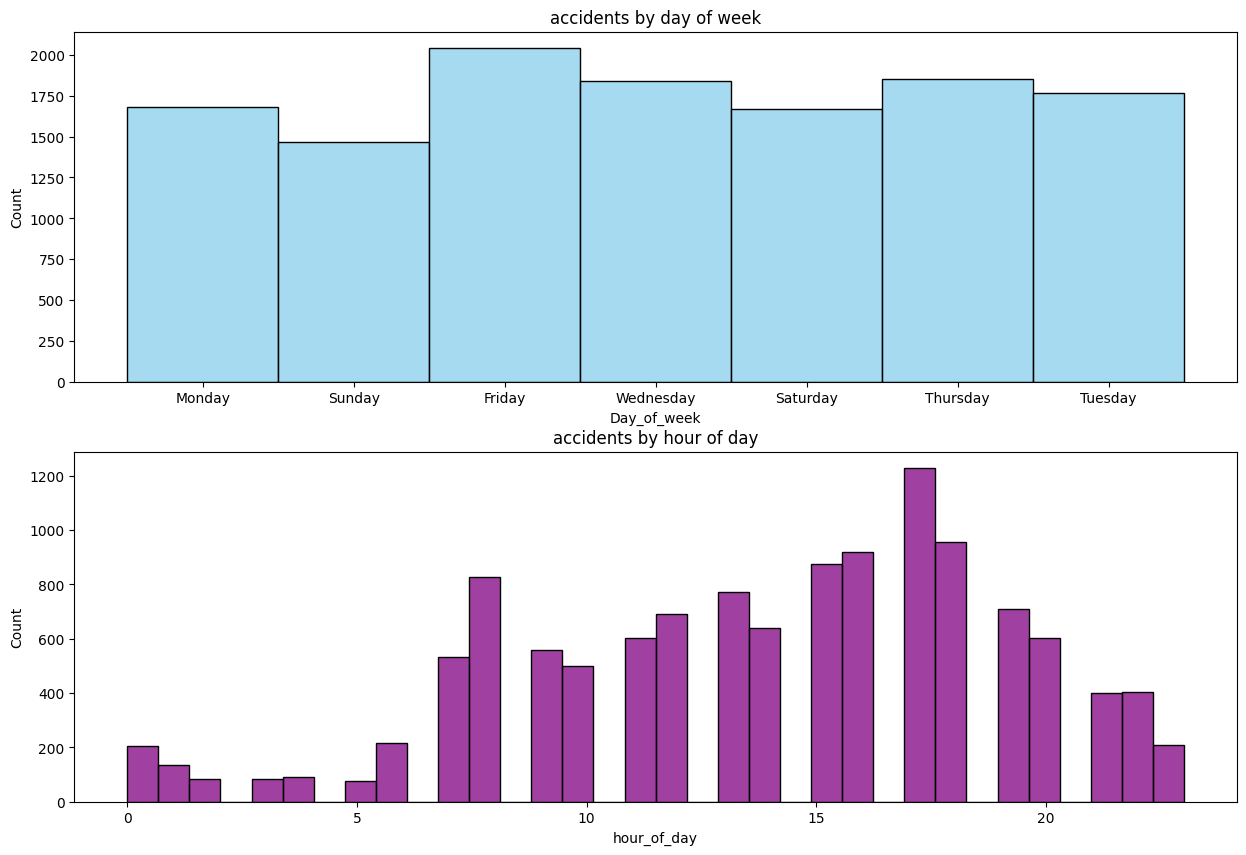

In [138]:
# time related plots

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.histplot(df['Day_of_week'], color='skyblue')
plt.title("accidents by day of week")

plt.subplot(2, 1, 2)
sns.histplot(df['hour_of_day'], color='purple')
plt.title('accidents by hour of day')


plt.show()

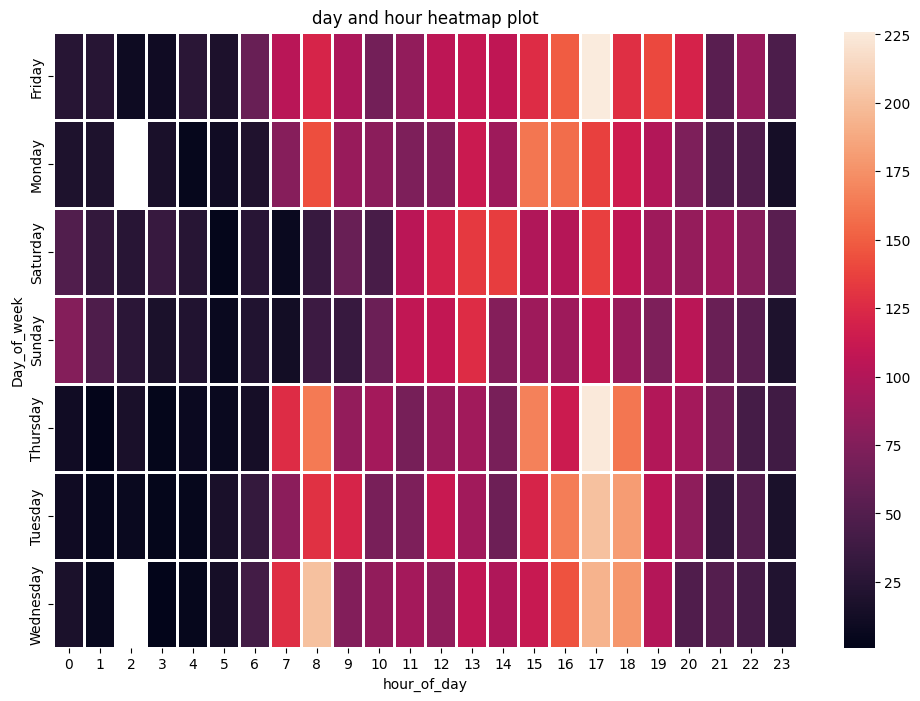

In [139]:
day_hour = df.pivot_table(index='Day_of_week', columns='hour_of_day', aggfunc='size')

plt.figure(figsize=(12, 8))
sns.heatmap(day_hour, linewidths=2, linecolor='white')
plt.title("day and hour heatmap plot")
plt.show()

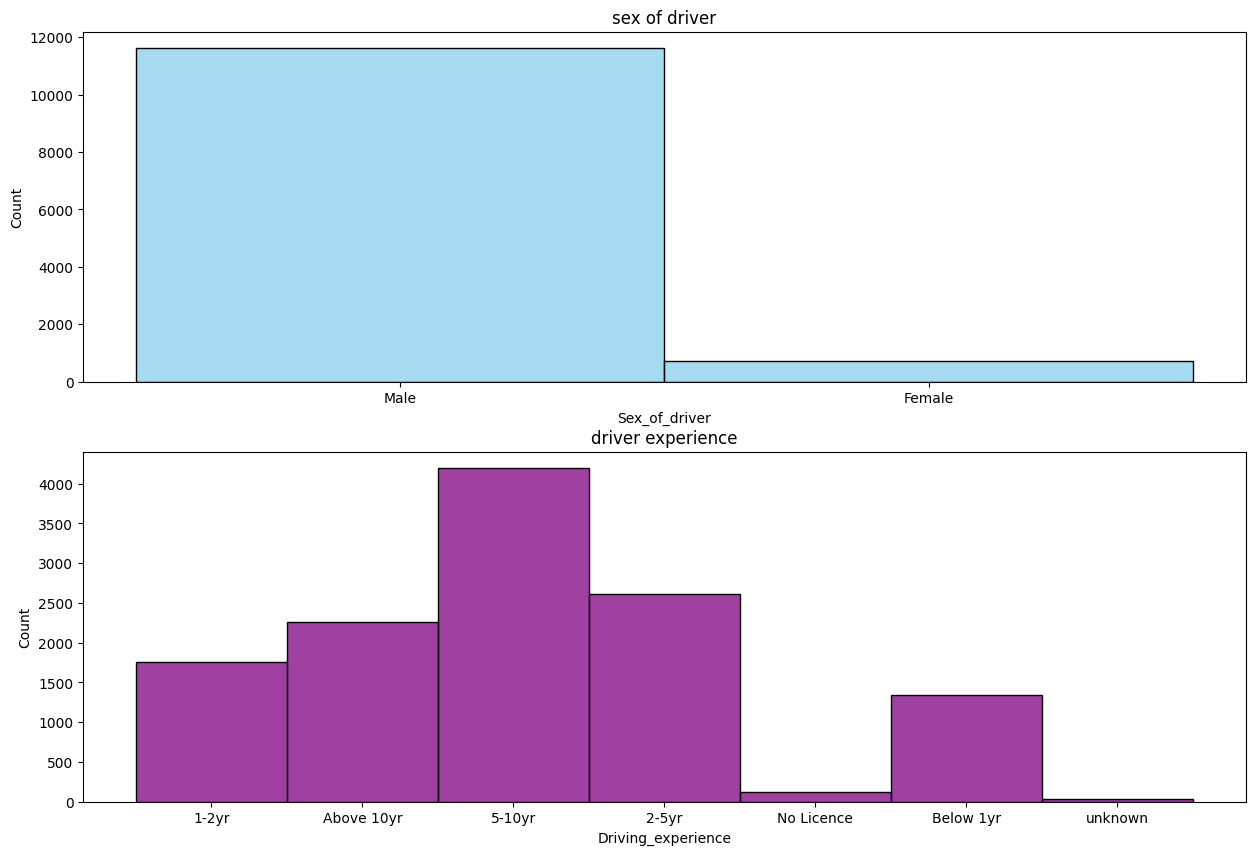

In [140]:
# driver related plots

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.histplot(df['Sex_of_driver'], color='skyblue')
plt.title("sex of driver")

plt.subplot(2, 1, 2)
sns.histplot(df['Driving_experience'], color='purple')
plt.title('driver experience')

plt.show()

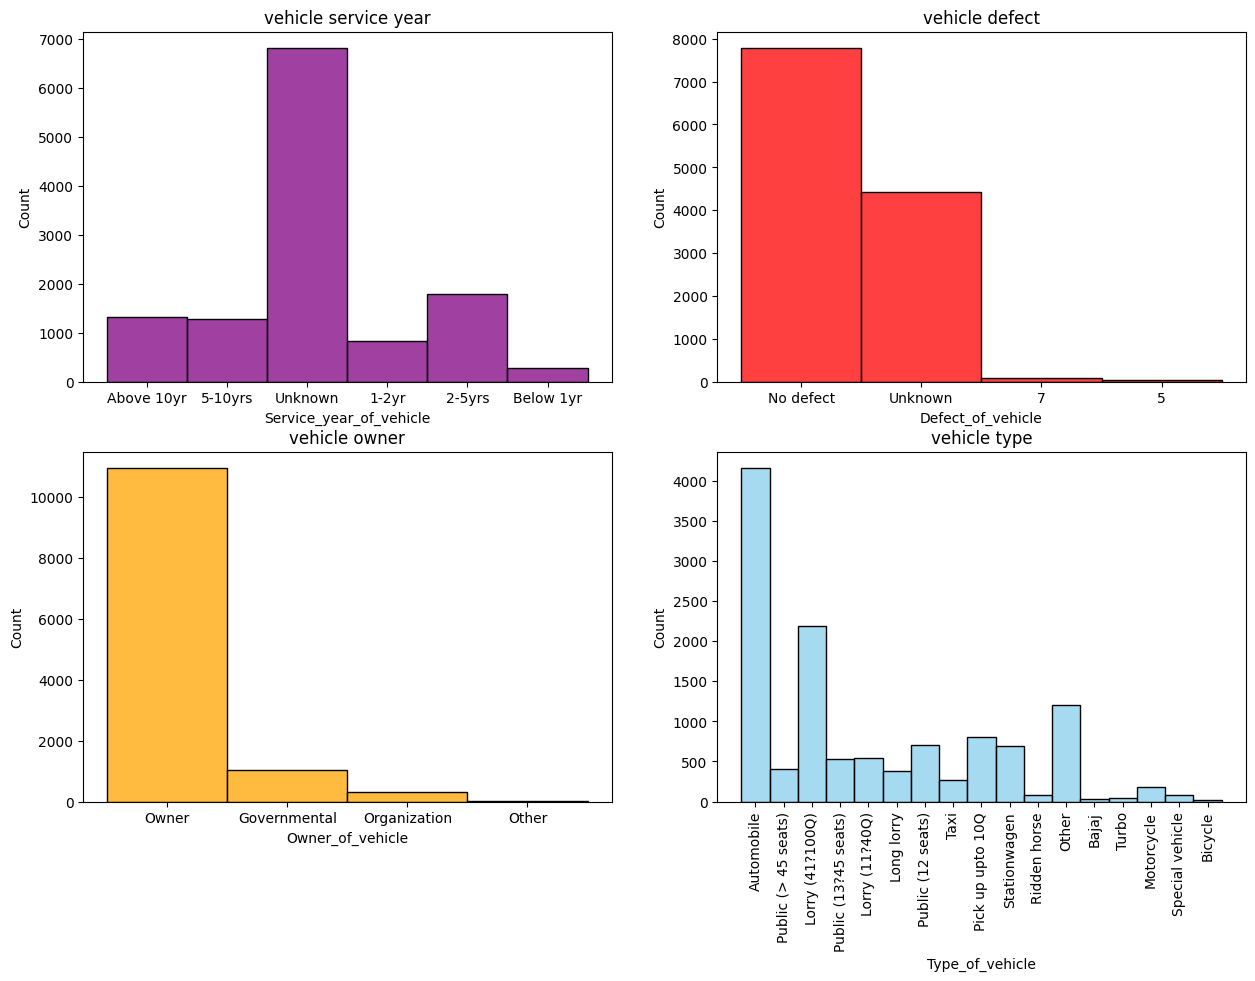

In [141]:
# car related plots

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Service_year_of_vehicle'], color='purple')
plt.title('vehicle service year')

plt.subplot(2, 2, 2)
sns.histplot(df['Defect_of_vehicle'], color='red')
plt.title("vehicle defect")

plt.subplot(2, 2, 3)
sns.histplot(df['Owner_of_vehicle'], color='orange')
plt.title('vehicle owner')

plt.subplot(2, 2, 4)
sns.histplot(df['Type_of_vehicle'], color='skyblue')
plt.xticks(rotation=90)
plt.title("vehicle type")


plt.show()

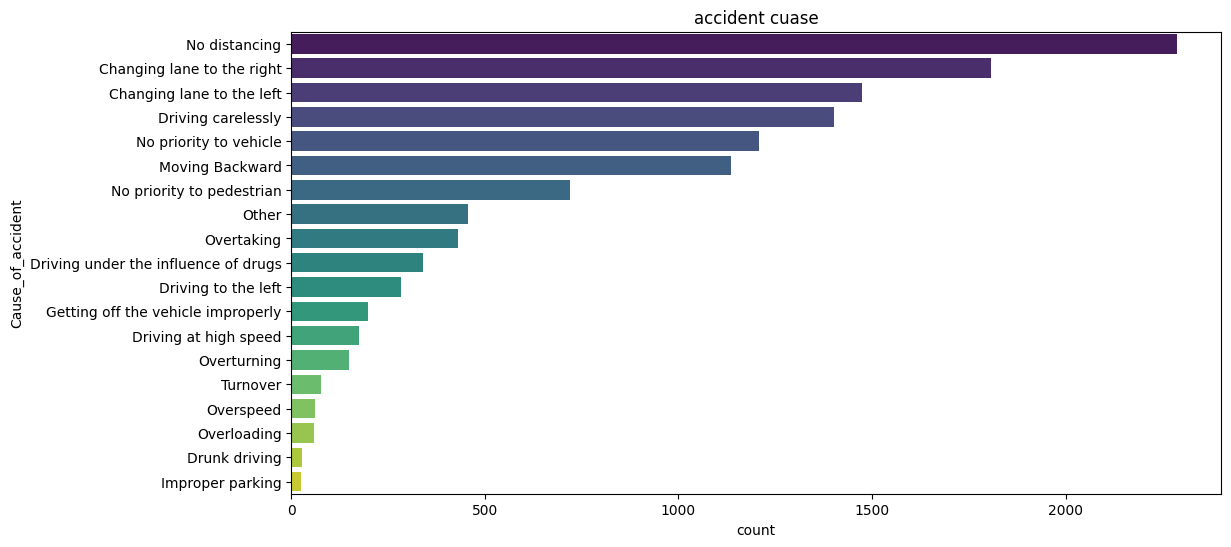

In [142]:
# accident cause plot
plt.figure(figsize=(12, 6))

data = df['Cause_of_accident'].value_counts()
index = data.index

sns.barplot(x=data, y=index, palette='viridis', hue=index)
plt.title('accident cuase')
plt.show()

## Preprocessing

In [143]:
df_copy = df.copy()

le = LabelEncoder()
for col in df_copy.select_dtypes(include='object').columns:
    df_copy[col] = le.fit_transform(df_copy[col])

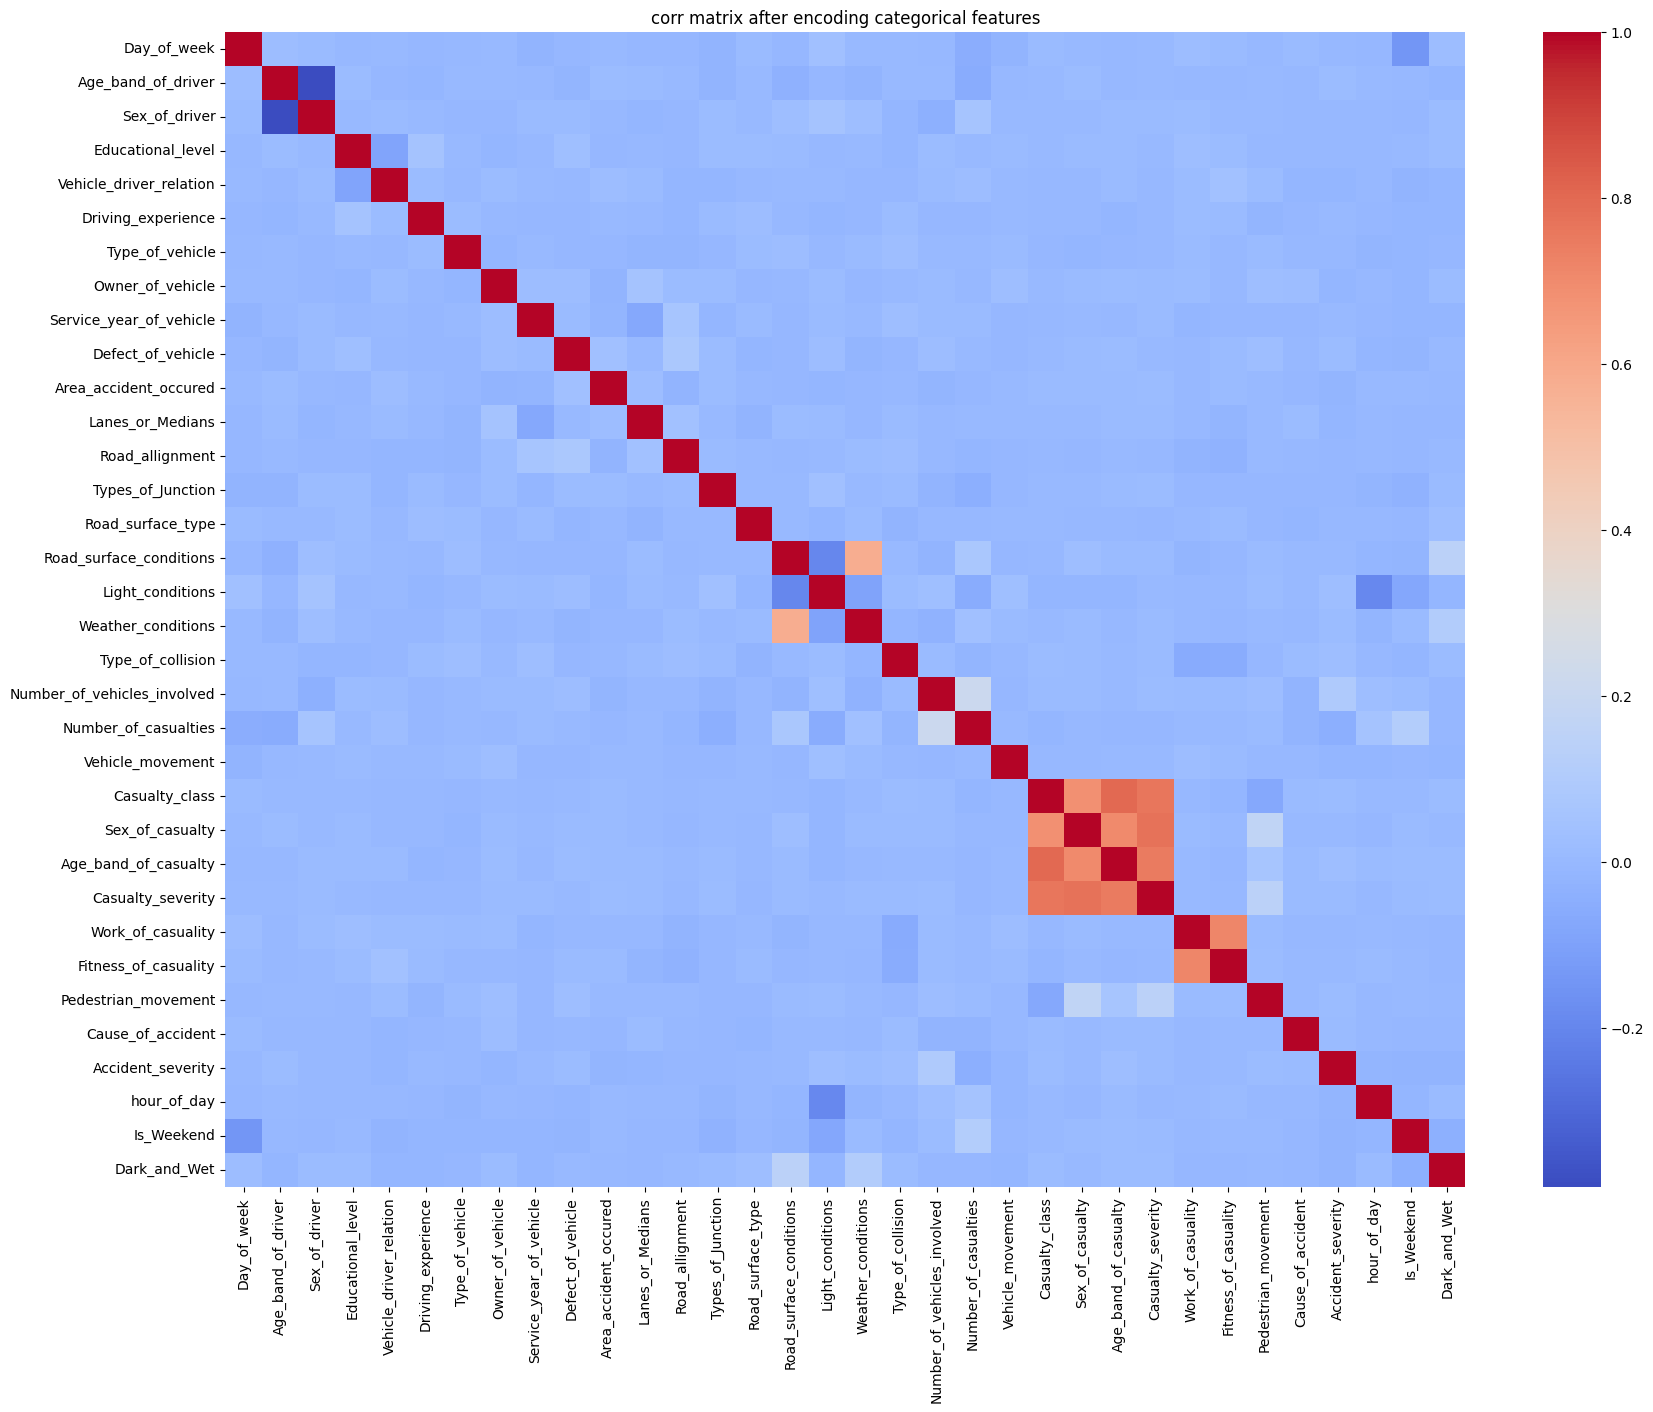

In [144]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_copy.corr(), cmap='coolwarm', annot=False)
plt.title('corr matrix after encoding categorical features')
plt.show()

In [145]:
X = df_copy.drop(columns=['Accident_severity'])
y = df_copy['Accident_severity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) 

## Feature Importance

In [114]:
cat = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    auto_class_weights='Balanced', 
    random_state = 42
)
cat.fit(X_train, y_train)

Learning rate set to 0.088315
0:	learn: 0.4524727	total: 4.89ms	remaining: 4.89s
1:	learn: 0.4780192	total: 9.81ms	remaining: 4.89s
2:	learn: 0.5204519	total: 14.8ms	remaining: 4.92s
3:	learn: 0.5347309	total: 25.5ms	remaining: 6.34s
4:	learn: 0.5596537	total: 31ms	remaining: 6.17s
5:	learn: 0.5604427	total: 36.4ms	remaining: 6.02s
6:	learn: 0.5652012	total: 43ms	remaining: 6.1s
7:	learn: 0.5767670	total: 50.5ms	remaining: 6.26s
8:	learn: 0.5861508	total: 56.6ms	remaining: 6.24s
9:	learn: 0.5875806	total: 62.4ms	remaining: 6.18s
10:	learn: 0.6031004	total: 65.5ms	remaining: 5.89s
11:	learn: 0.6037758	total: 67.8ms	remaining: 5.58s
12:	learn: 0.6168352	total: 70ms	remaining: 5.31s
13:	learn: 0.6094268	total: 73ms	remaining: 5.14s
14:	learn: 0.6151518	total: 76.6ms	remaining: 5.03s
15:	learn: 0.6195235	total: 79.7ms	remaining: 4.9s
16:	learn: 0.6187810	total: 83.1ms	remaining: 4.81s
17:	learn: 0.6317426	total: 86.4ms	remaining: 4.71s
18:	learn: 0.6448411	total: 89.9ms	remaining: 4.64s
19

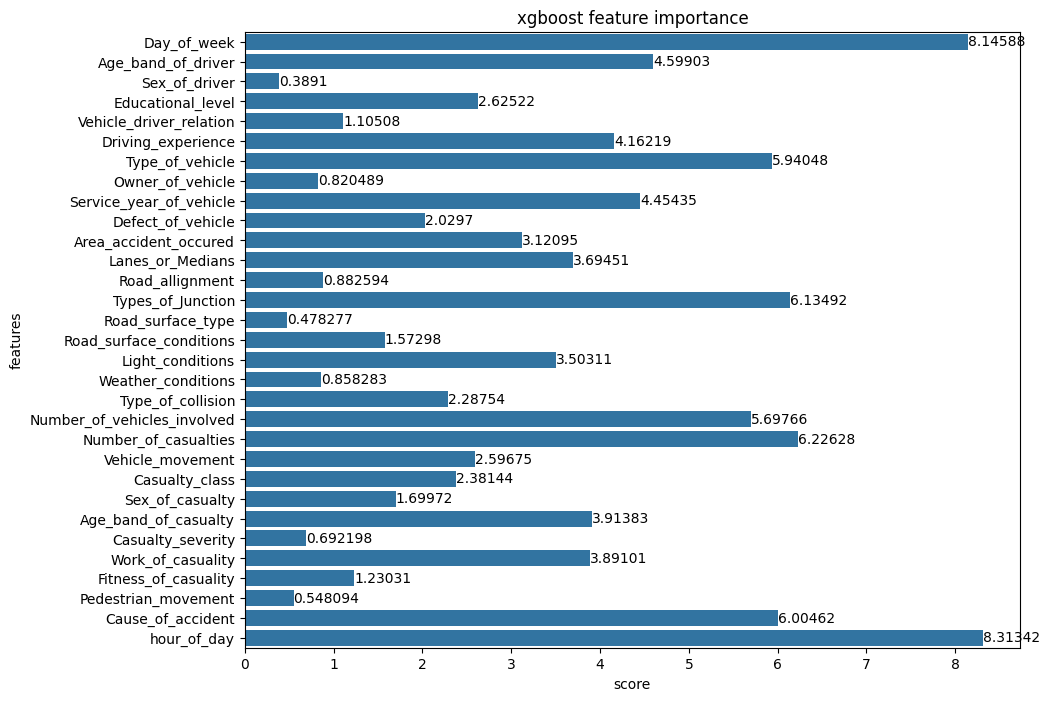

In [117]:
importances = cat.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=importances, y=feature_names)
ax.bar_label(ax.containers[0])
plt.title('xgboost feature importance')
plt.xlabel('score')
plt.ylabel('features')
plt.show()

## Model Training With Grid Search

In [147]:
cat_grid = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=2
)


grid_param_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8], 
    'l2_leaf_reg': [1, 3, 5, 7]
}


grid_search_cat = GridSearchCV(
    estimator=cat_grid,
    param_grid=grid_param_cat,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0:	learn: 0.4285589	total: 51.2ms	remaining: 5.06s
0:	learn: 0.4451525	total: 53.7ms	remaining: 5.31s
2:	learn: 0.4653370	total: 60.5ms	remaining: 1.96s
0:	learn: 0.4397719	total: 53.1ms	remaining: 5.26s
2:	learn: 0.4693907	total: 57.8ms	remaining: 1.87s
4:	learn: 0.4700907	total: 67.5ms	remaining: 1.28s
2:	learn: 0.4556512	total: 66.2ms	remaining: 2.14s
4:	learn: 0.4791451	total: 64.8ms	remaining: 1.23s
6:	learn: 0.4607310	total: 75.1ms	remaining: 998ms
4:	learn: 0.4642106	total: 71.7ms	remaining: 1.36s
8:	learn: 0.4687983	total: 80.4ms	remaining: 813ms
6:	learn: 0.4886359	total: 78.4ms	remaining: 1.04s
0:	learn: 0.3938560	total: 49.3ms	remaining: 4.88s
6:	learn: 0.4838219	total: 79.7ms	remaining: 1.06s
8:	learn: 0.4846893	total: 92.4ms	remaining: 934ms
2:	learn: 0.4995514	total: 60.8ms	remaining: 1.96s
0:	learn: 0.3938560	total: 53.4ms	remaining: 5.29s
2:	learn: 0.5010632	total: 61ms	remaining: 1.97s
4:	learn: 0.5110230	t

In [148]:
print("Best Params:", grid_search_cat.best_params_)

Best Params: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [149]:
best_model = grid_search_cat.best_estimator_
y_pred = best_model.predict(X_test)

print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

           0       0.22      0.47      0.30        47
           1       0.25      0.37      0.30       523
           2       0.88      0.79      0.84      3125

    accuracy                           0.73      3695
   macro avg       0.45      0.54      0.48      3695
weighted avg       0.78      0.73      0.75      3695



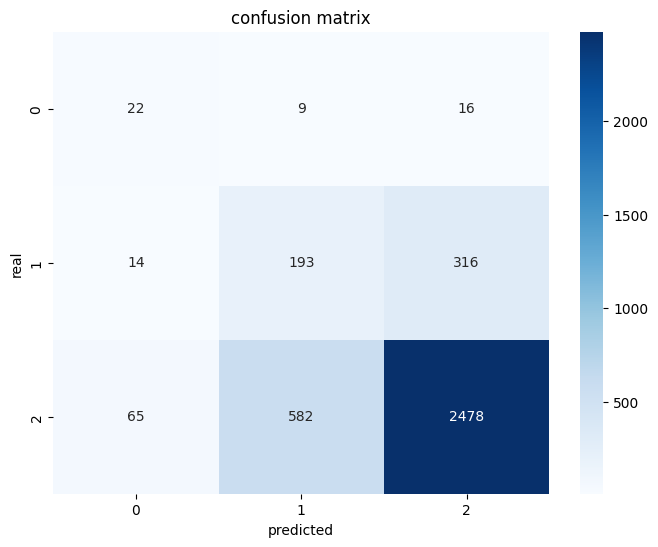

In [150]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()